In [ ]:
#@title Importing requried libraries

import kagglehub
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:

#@title Loading Dataset from Kaggle

path = kagglehub.dataset_download("sshikamaru/car-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sshikamaru/car-object-detection/versions/2


In [ ]:
image_folder = "/root/.cache/kagglehub/datasets/sshikamaru/car-object-detection/versions/2/data/training_images"
bbox_df = pd.read_csv("/root/.cache/kagglehub/datasets/sshikamaru/car-object-detection/versions/2/data/train_solution_bounding_boxes (1).csv")

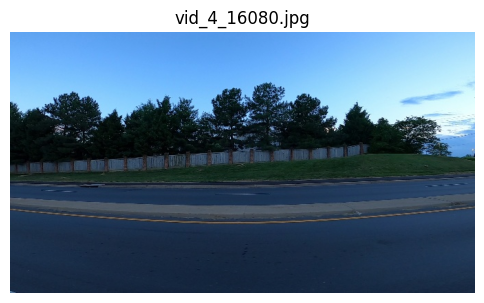

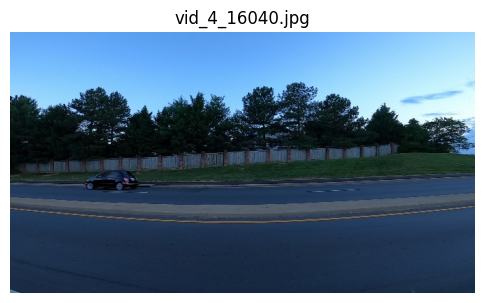

In [ ]:
# Load images
def load_images(image_folder):
    images = {}
    for filename in os.listdir(image_folder):
        #print(filename)
        if filename.endswith(".jpg") or filename.endswith(".PNG"):
            img_path = os.path.join(image_folder, filename)
            images[filename] = cv2.imread(img_path)
    return images

# Visualize a single image
def visualize_image(image, image_name):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(image_name)
    plt.axis("off")
    plt.show()

# Load and display images
images = load_images(image_folder)
image_filenames = list(images.keys())
visualize_image(images[image_filenames[50]], image_filenames[50])
visualize_image(images[image_filenames[25]], image_filenames[25])

In [ ]:
#@title Extracting SIFT Features

def extract_sift_features(img, max_features=100):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None:  # If no descriptors found
        return np.zeros((max_features * 128,))

    # Pad or truncate to maintain fixed size
    if len(descriptors) < max_features:
        descriptors = np.pad(descriptors, ((0, max_features - len(descriptors)), (0, 0)), mode='constant')
    else:
        descriptors = descriptors[:max_features]

    return descriptors.flatten()

In [ ]:
# Images that appear exactly once → Test Set
test_df = bbox_df[bbox_df['image'].map(bbox_df['image'].value_counts()) == 1]

# Images that appear more than once → Train Set
train_df = bbox_df[bbox_df['image'].map(bbox_df['image'].value_counts()) > 1]

images_to_move = test_df['image'].sample(n=186, random_state=42)

# Move selected images to train_df
train_df = pd.concat([train_df, test_df[test_df['image'].isin(images_to_move)]], ignore_index=True)

# Remove the moved images from test_df
test_df = test_df[~test_df['image'].isin(images_to_move)]

# Print updated dataset sizes
print(f"New Train Set Size: {len(train_df)}")
print(f"New Test Set Size: {len(test_df)}")


New Train Set Size: 509
New Test Set Size: 50


In [ ]:
from tqdm import tqdm

# Initialize lists for training and testing sets
X_train, y_train, X_test, y_test = [], [], [], []

# Process training set
for _, row in tqdm(train_df.iterrows(), desc="Processing Train Data"):
    image_name = row["image"]
    if image_name in images:
        img = images[image_name]
        features = extract_sift_features(img)
        X_train.append(features)
        y_train.append([row["xmin"], row["ymin"], row["xmax"], row["ymax"]])

# Process testing set
for _, row in tqdm(test_df.iterrows(), desc="Processing Test Data"):
    image_name = row["image"]
    if image_name in images:
        img = images[image_name]
        features = extract_sift_features(img)
        X_test.append(features)
        y_test.append([row["xmin"], row["ymin"], row["xmax"], row["ymax"]])

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)


Processing Train Data: 509it [00:38, 13.25it/s]
Processing Test Data: 50it [00:03, 15.04it/s]


In [ ]:
len(X_train[0])

12800

In [ ]:
X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,...,12790,12791,12792,12793,12794,12795,12796,12797,12798,12799
0,49.0,4.0,0.0,0.0,0.0,40.0,93.0,49.0,71.0,4.0,...,0.0,6.0,14.0,8.0,7.0,55.0,156.0,1.0,0.0,0.0
1,49.0,4.0,0.0,0.0,0.0,40.0,93.0,49.0,71.0,4.0,...,0.0,6.0,14.0,8.0,7.0,55.0,156.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,...,8.0,44.0,135.0,118.0,0.0,0.0,0.0,0.0,2.0,3.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,...,8.0,44.0,135.0,118.0,0.0,0.0,0.0,0.0,2.0,3.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,...,8.0,44.0,135.0,118.0,0.0,0.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,7.0,42.0,17.0,8.0,2.0,1.0,0.0,1.0,23.0,53.0,...,3.0,7.0,5.0,14.0,40.0,30.0,66.0,26.0,3.0,7.0
505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,12.0,0.0,1.0,7.0,110.0,61.0,0.0,0.0,0.0
506,9.0,1.0,0.0,0.0,3.0,6.0,10.0,21.0,14.0,1.0,...,5.0,88.0,46.0,1.0,3.0,46.0,44.0,0.0,0.0,16.0
507,35.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,152.0,0.0,...,6.0,5.0,143.0,62.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
len(X_train.columns)

12800

In [ ]:
print(f"Shape of Train Data before reduction: {X_train.shape}\nShape of Test Data before reduction: {X_test.shape}")

Shape of Train Data before reduction: (509, 12800)
Shape of Test Data before reduction: (50, 12800)


**SCREE PLOT**

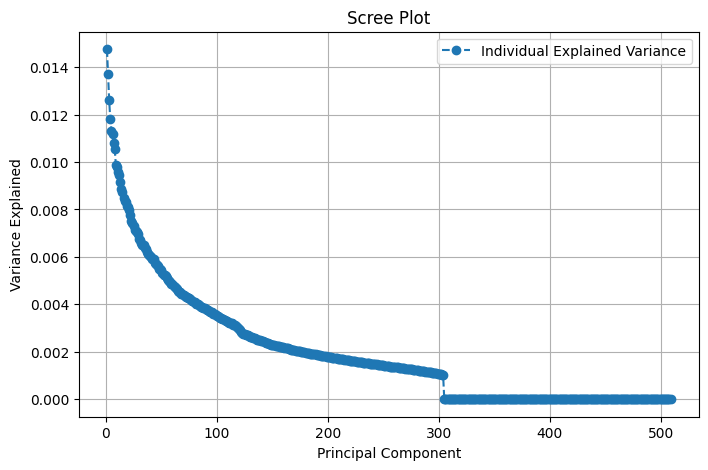

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA on training features without specifying components
pca_full = PCA()
pca_full.fit(X_train)

# Get explained variance ratio
explained_variance = pca_full.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label="Individual Explained Variance")
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()


PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Define PCA with enough components to explain 95% variance
pca = PCA(n_components=300)

# Fit PCA on training features and transform both train & test sets
X_train_pca = pca.fit_transform(np.array(X_train))
X_test_pca = pca.transform(np.array(X_test))

# Check the new shape after PCA
print(f"Shape of Train Data after reduction: {X_train_pca.shape}\nShape of Test Data after reduction: {X_test_pca.shape}\n\n")


X_train_pca = pd.DataFrame(X_train_pca)

X_train_pca


Shape of Train Data after reduction: (509, 300)
Shape of Test Data after reduction: (50, 300)




,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-29.778868,-450.427155,-286.107147,-136.017120,-183.324905,-138.809464,-152.032303,117.459633,-25.847839,33.111347,...,-81.994827,-46.365784,16.505829,-49.357975,-80.530602,11.490349,-67.439735,67.144081,-31.420349,-13.709916
1,-29.777349,-450.427368,-286.108093,-136.018143,-183.325043,-138.809525,-152.032776,117.461433,-25.846876,33.110912,...,-81.994881,-46.366154,16.505857,-49.357990,-80.530647,11.490064,-67.439705,67.144241,-31.420324,-13.709628
2,395.974213,-386.734589,-397.715332,-61.969048,-278.063141,-87.772377,-512.800232,-237.010956,-135.675430,-123.443611,...,-39.294739,14.687349,-1.757376,21.904394,-5.027307,23.214272,51.563931,-2.509528,-15.225801,3.543412
3,395.975128,-386.734009,-397.715912,-61.971050,-278.063416,-87.774689,-512.798950,-237.011734,-135.676941,-123.444565,...,-39.294579,14.687561,-1.757546,21.904457,-5.027382,23.214249,51.563915,-2.509609,-15.225891,3.543519
4,395.974976,-386.733704,-397.715363,-61.970810,-278.062988,-87.774750,-512.798889,-237.010712,-135.675552,-123.445679,...,-39.294537,14.687664,-1.757555,21.904203,-5.027390,23.214375,51.563808,-2.509552,-15.225842,3.543312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,-77.469078,-177.698792,-2.345028,-79.691154,51.405636,-53.973530,52.093975,63.640228,-10.519659,-50.025124,...,57.364109,458.570770,-345.447784,12.221261,-23.658823,290.856598,113.741585,261.819794,137.585724,-36.873852
505,-37.308475,150.204636,248.302551,183.879288,-106.917130,70.670128,-9.471437,101.412895,-121.355698,-88.101585,...,181.364441,-155.223358,-71.859451,-64.624496,212.132401,-95.433220,178.682938,283.205048,138.019333,104.568947
506,-82.346848,342.615997,88.256828,54.022350,69.858955,15.422532,107.947067,-82.414169,-36.803207,-57.038910,...,61.689495,305.845490,96.852409,91.109253,68.865631,-149.145081,54.433109,-121.932442,-472.765076,-297.491516
507,-93.712425,166.267365,228.693619,-114.071251,83.177299,42.840027,-265.661804,92.138496,-289.555450,-34.113422,...,-277.655151,148.860168,-123.115517,-498.794495,82.612503,29.656084,67.589310,346.731201,327.240173,-125.330910


In [ ]:
#@title Model Training

models = {}  # Dictionary to store models
predictions = {}  # Dictionary to store predictions

import pandas as pd

# Ensure X_train and X_test have consistent column names
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Define label indices
label_indices = {"xmin": 0, "ymin": 1, "xmax": 2, "ymax": 3}

# Train the model
for label, i in label_indices.items():
    models[label] = xgb.XGBRegressor(
        booster="gbtree",
        objective="reg:squarederror",
        learning_rate=0.05,
        n_estimators=500,
        max_depth=8,
        min_child_weight=2,
        gamma=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.5,
        tree_method="hist",
        n_jobs=-1,
        verbosity=1,
        random_state=42
    )
    models[label].fit(X_train, y_train[:, i])  # Now 'i' is properly defined


# Align test data
X_test = X_test[X_train.columns]




In [ ]:
# Predict\
for label in ["xmin", "ymin", "xmax", "ymax"]:
  predictions[label] = {
          "train": models[label].predict(X_train),
          "test": models[label].predict(X_test)
      }


In [ ]:
#@title Intersection over Union (IoU) for Evaluation
def calculate_iou(y_true, y_pred):
    """Calculates the IoU score for bounding box predictions."""
    xA = np.maximum(y_true[:, 0], y_pred[:, 0])
    yA = np.maximum(y_true[:, 1], y_pred[:, 1])
    xB = np.minimum(y_true[:, 2], y_pred[:, 2])
    yB = np.minimum(y_true[:, 3], y_pred[:, 3])

    # Compute the area of intersection
    inter_area = np.maximum(0, xB - xA) * np.maximum(0, yB - yA)

    # Compute the area of both the actual and predicted bounding boxes
    boxA_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    boxB_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])

    # Compute IoU
    iou = inter_area / (boxA_area + boxB_area - inter_area + 1e-9)
    print("hi")  # Adding small value to prevent division by zero
    return np.mean(iou)  # Returning mean IoU across all samples

In [ ]:
#@title Performance Evaluation

# Convert predictions to array format for evaluation
y_train_pred_combined = np.column_stack([predictions[label]["train"] for label in ["xmin", "ymin", "xmax", "ymax"]])
y_test_pred_combined = np.column_stack([predictions[label]["test"] for label in ["xmin", "ymin", "xmax", "ymax"]])

def evaluate_model(y_true, y_pred, label, dataset_type="Test"):
    """Computes actual evaluation metrics for each bounding box label."""

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"=== {label} Model {dataset_type} Evaluation ===")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}\n")


# Compute IoU scores separately for train and test
iou_train = calculate_iou(y_train, y_train_pred_combined)
iou_test = calculate_iou(y_test, y_test_pred_combined)

# Evaluate each model separately for both train and test datasets
for label, idx in zip(["xmin", "ymin", "xmax", "ymax"], range(4)):
    evaluate_model(y_train[:, idx], y_train_pred_combined[:, idx], label, dataset_type="Train")
    evaluate_model(y_test[:, idx], y_test_pred_combined[:, idx], label, dataset_type="Test")

# Print IoU for training and testing separately
print(f"=== Overall IoU Scores ===")
print(f"Train IoU: {iou_train:.4f}")
print(f"Test IoU: {iou_test:.4f}\n")


hi
hi
=== xmin Model Train Evaluation ===
MSE: 42924.63
RMSE: 207.18
MAE: 182.57
R² Score: -0.00

=== xmin Model Test Evaluation ===
MSE: 42940.84
RMSE: 207.22
MAE: 181.69
R² Score: -0.00

=== ymin Model Train Evaluation ===
MSE: 86.47
RMSE: 9.30
MAE: 7.69
R² Score: -0.00

=== ymin Model Test Evaluation ===
MSE: 88.27
RMSE: 9.40
MAE: 7.57
R² Score: -0.00

=== xmax Model Train Evaluation ===
MSE: 45386.64
RMSE: 213.04
MAE: 188.60
R² Score: -0.00

=== xmax Model Test Evaluation ===
MSE: 46676.83
RMSE: 216.05
MAE: 189.54
R² Score: -0.00

=== ymax Model Train Evaluation ===
MSE: 202.62
RMSE: 14.23
MAE: 10.33
R² Score: -0.00

=== ymax Model Test Evaluation ===
MSE: 120.94
RMSE: 11.00
MAE: 8.67
R² Score: -0.01

=== Overall IoU Scores ===
Train IoU: 0.0711
Test IoU: 0.0839



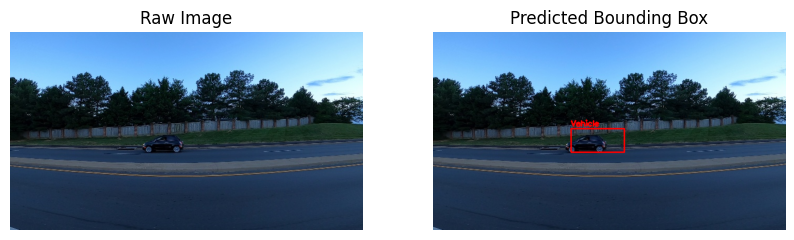

In [ ]:
#@title Example Inference

def draw_bbox(image, bbox, color, label):
    """Draws a bounding box on the image."""
    image_copy = image.copy()
    xmin, ymin, xmax, ymax = map(int, bbox)  # Convert to integers
    cv2.rectangle(image_copy, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(image_copy, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image_copy

# Select one image for inference
idx = 10  # Example index from the test set
image_name = test_df.iloc[idx]["image"]
raw_image = images[image_name]

# Extract predicted bounding box
y_pred = [predictions[label]["test"][idx] for label in ["xmin", "ymin", "xmax", "ymax"]]

# Draw predicted bounding box (Red)
image_pred = draw_bbox(raw_image, y_pred, (0, 0, 255), "Vehicle")

# Display raw and predicted images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
plt.title("Raw Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_pred, cv2.COLOR_BGR2RGB))
plt.title("Predicted Bounding Box")
plt.axis("off")

plt.show()

In [ ]:
#@title Model Training

models = {}  # Dictionary to store models
predictions = {}  # Dictionary to store predictions

import pandas as pd

# Ensure X_train and X_test have consistent column names
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Define label indices
label_indices = {"xmin": 0, "ymin": 1, "xmax": 2, "ymax": 3}

# Train the model
for label, i in label_indices.items():
    models[label] = xgb.XGBRegressor(
        booster="gblinear",
        objective="reg:squarederror",
        reg_lambda=0.5,
        tree_method="hist",
        n_jobs=-1,
        verbosity=1,
        random_state=42
    )
    models[label].fit(X_train, y_train[:, i])  # Now 'i' is properly defined


# Align test data
X_test = X_test[X_train.columns]




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Predict\
for label in ["xmin", "ymin", "xmax", "ymax"]:
  predictions[label] = {
          "train": models[label].predict(X_train),
          "test": models[label].predict(X_test)
      }


In [ ]:
#@title Intersection over Union (IoU) for Evaluation
def calculate_iou(y_true, y_pred):
    """Calculates the IoU score for bounding box predictions."""
    xA = np.maximum(y_true[:, 0], y_pred[:, 0])
    yA = np.maximum(y_true[:, 1], y_pred[:, 1])
    xB = np.minimum(y_true[:, 2], y_pred[:, 2])
    yB = np.minimum(y_true[:, 3], y_pred[:, 3])

    # Compute the area of intersection
    inter_area = np.maximum(0, xB - xA) * np.maximum(0, yB - yA)

    # Compute the area of both the actual and predicted bounding boxes
    boxA_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    boxB_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])

    # Compute IoU
    iou = inter_area / (boxA_area + boxB_area - inter_area + 1e-9)
    print("hi")  # Adding small value to prevent division by zero
    return np.mean(iou)  # Returning mean IoU across all samples

In [ ]:
#@title Performance Evaluation

# Convert predictions to array format for evaluation
y_train_pred_combined = np.column_stack([predictions[label]["train"] for label in ["xmin", "ymin", "xmax", "ymax"]])
y_test_pred_combined = np.column_stack([predictions[label]["test"] for label in ["xmin", "ymin", "xmax", "ymax"]])

def evaluate_model(y_true, y_pred, label, dataset_type="Test"):
    """Computes actual evaluation metrics for each bounding box label."""

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"=== {label} Model {dataset_type} Evaluation ===")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}\n")


# Compute IoU scores separately for train and test
iou_train = calculate_iou(y_train, y_train_pred_combined)
iou_test = calculate_iou(y_test, y_test_pred_combined)

# Evaluate each model separately for both train and test datasets
for label, idx in zip(["xmin", "ymin", "xmax", "ymax"], range(4)):
    evaluate_model(y_train[:, idx], y_train_pred_combined[:, idx], label, dataset_type="Train")
    evaluate_model(y_test[:, idx], y_test_pred_combined[:, idx], label, dataset_type="Test")

# Print IoU for training and testing separately
print(f"=== Overall IoU Scores ===")
print(f"Train IoU: {iou_train:.4f}")
print(f"Test IoU: {iou_test:.4f}\n")


hi
hi
=== xmin Model Train Evaluation ===
MSE: 42923.12
RMSE: 207.18
MAE: 182.47
R² Score: -0.00

=== xmin Model Test Evaluation ===
MSE: 42941.03
RMSE: 207.22
MAE: 181.59
R² Score: -0.00

=== ymin Model Train Evaluation ===
MSE: 86.47
RMSE: 9.30
MAE: 7.69
R² Score: -0.00

=== ymin Model Test Evaluation ===
MSE: 88.29
RMSE: 9.40
MAE: 7.57
R² Score: -0.00

=== xmax Model Train Evaluation ===
MSE: 45385.41
RMSE: 213.04
MAE: 188.55
R² Score: -0.00

=== xmax Model Test Evaluation ===
MSE: 46680.46
RMSE: 216.06
MAE: 189.54
R² Score: -0.00

=== ymax Model Train Evaluation ===
MSE: 202.62
RMSE: 14.23
MAE: 10.34
R² Score: -0.00

=== ymax Model Test Evaluation ===
MSE: 120.86
RMSE: 10.99
MAE: 8.67
R² Score: -0.01

=== Overall IoU Scores ===
Train IoU: 0.0713
Test IoU: 0.0841



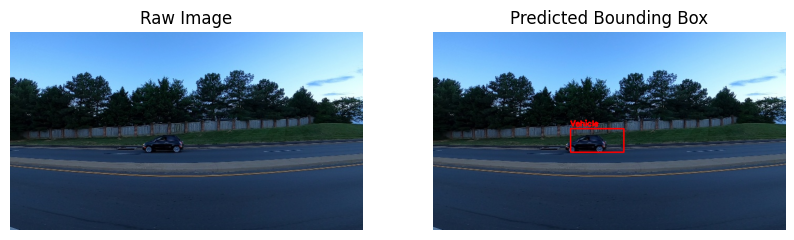

In [ ]:
#@title Example Inference

def draw_bbox(image, bbox, color, label):
    """Draws a bounding box on the image."""
    image_copy = image.copy()
    xmin, ymin, xmax, ymax = map(int, bbox)  # Convert to integers
    cv2.rectangle(image_copy, (xmin, ymin), (xmax, ymax), color, 2)
    cv2.putText(image_copy, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image_copy

# Select one image for inference
idx = 10  # Example index from the test set
image_name = test_df.iloc[idx]["image"]
raw_image = images[image_name]

# Extract predicted bounding box
y_pred = [predictions[label]["test"][idx] for label in ["xmin", "ymin", "xmax", "ymax"]]

# Draw predicted bounding box (Red)
image_pred = draw_bbox(raw_image, y_pred, (0, 0, 255), "Vehicle")

# Display raw and predicted images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
plt.title("Raw Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_pred, cv2.COLOR_BGR2RGB))
plt.title("Predicted Bounding Box")
plt.axis("off")

plt.show()